### Imports

In [17]:
from main import QuantumIR
from qiskit_aer import AerSimulator
from qiskit import QuantumCircuit
import numpy as np

### Generate the IR

In [127]:
# Run
quantum_ir = QuantumIR()
quantum_ir.run_dataclass()
quantum_ir.run_generate_ir()
quantum_ir.run_transformations()


IR:

builtin.module {
  "quantum.func"() ({
  ^0(%q0_0 : i1, %q1_0 : i1):
    %q2_0 = "quantum.init"() {"type" = i1, "value" = false} : () -> i1
    %q2_1 = "quantum.ccnot"(%q0_0, %q1_0, %q2_0) : (i1, i1, i1) -> i1
    %q2_2 = "quantum.measure"(%q2_1) : (i1) -> i1
  }) {"func_name" = "And"} : () -> ()
}

Transformations:


No more transformations possible


Final IR:

builtin.module {
  "quantum.func"() ({
  ^0(%q0_0 : i1, %q1_0 : i1):
    %q2_0 = "quantum.init"() {"type" = i1, "value" = false} : () -> i1
    %q2_1 = "quantum.ccnot"(%q0_0, %q1_0, %q2_0) : (i1, i1, i1) -> i1
    %q2_2 = "quantum.measure"(%q2_1) : (i1) -> i1
  }) {"func_name" = "And"} : () -> ()
}




### Transform CCNOT gates

In [135]:
quantum_ir.metrics_transformation()
quantum_ir.run_transformations()



CCNOT decomposition:

builtin.module {
  "quantum.func"() ({
  ^0(%q0_0 : i1, %q1_0 : i1):
    %q2_0 = "quantum.init"() {"type" = i1, "value" = false} : () -> i1
    %q2_1 = "quantum.h"(%q2_0) : (i1) -> i1
    %q2_2 = "quantum.cnot"(%q1_0, %q2_1) : (i1, i1) -> i1
    %q2_3 = "quantum.tdagger"(%q2_2) : (i1) -> i1
    %q2_4 = "quantum.cnot"(%q0_0, %q2_3) : (i1, i1) -> i1
    %q2_5 = "quantum.t"(%q2_4) : (i1) -> i1
    %q2_6 = "quantum.cnot"(%q1_0, %q2_5) : (i1, i1) -> i1
    %q2_7 = "quantum.tdagger"(%q2_6) : (i1) -> i1
    %q2_8 = "quantum.cnot"(%q0_0, %q2_7) : (i1, i1) -> i1
    %q1_1 = "quantum.cnot"(%q0_0, %q1_0) : (i1, i1) -> i1
    %q1_2 = "quantum.tdagger"(%q1_1) : (i1) -> i1
    %q1_3 = "quantum.cnot"(%q0_0, %q1_2) : (i1, i1) -> i1
    %q0_1 = "quantum.t"(%q0_0) : (i1) -> i1
    %q1_4 = "quantum.t"(%q1_3) : (i1) -> i1
    %q2_9 = "quantum.t"(%q2_8) : (i1) -> i1
    %q2_10 = "quantum.h"(%q2_9) : (i1) -> i1
    %q2_11 = "quantum.measure"(%q2_10) : (i1) -> i1
  }) {"func_name" = "

### Find input and output number

In [136]:
module = quantum_ir.module
funcOp = module.body.block._first_op

# Numbers and type of the input parameters
input_args = funcOp.body.block._args
input_number = input_args.__len__()
input_types = [arg.type for arg in input_args]

# First and last op
first_op = funcOp.body.block._first_op
last_op = funcOp.body.block._last_op
output_number = 0
init_number = 0

current = first_op
while(current is not None):
    if current.name == "quantum.init":
        input_number += 1
        init_number += 1
    if current.name == "quantum.measure":
        output_number += 1
    current = current.next_op

print("Number of inputs: ", input_number, "Number of outputs: ", output_number)

Number of inputs:  3 Number of outputs:  1


### Initialize circuit

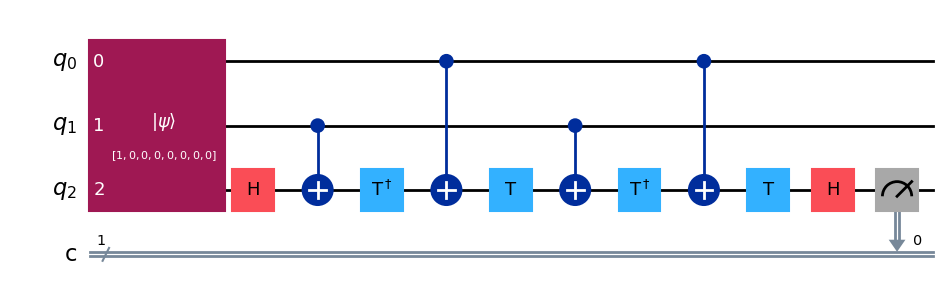

In [137]:

def create_circuit(first_op, input_number, output_number, state):

    circuit = QuantumCircuit(input_number, output_number)
    current = first_op
    cbit_index = 0

    qubit_list = [i for i in range(input_number)]

    circuit.initialize(state, qubit_list)

    while(current is not None):
        # find the indexes of the qubit
        operands_names = [op._name for op in current.operands]
        indexes = [int(name.split("_")[0][1]) for name in operands_names]
        if current.name == "quantum.not":
            circuit.x(indexes[0])
        if current.name  == "quantum.cnot":
            circuit.cx(indexes[0], indexes[1])
        if current.name == "quantum.ccnot":
            circuit.ccx(indexes[0], indexes[1], indexes[2])
        if current.name == "quantum.h":
            circuit.h(indexes[0])
        if current.name == "quantum.t":
            circuit.t(indexes[0])
        if current.name == "quantum.tdagger":
            circuit.tdg(indexes[0])
        if current.name == "quantum.measure":
            circuit.measure(indexes[0], cbit_index)
            cbit_index += 1
        
        current = current.next_op
    
    return circuit

# initializing it to an example state (e.g. all qubit at 0)
example_state = np.array([1] + [0] * (2**input_number - 1))
create_circuit(first_op, input_number, output_number,example_state).draw(output='mpl')



### Truth tables

In [138]:
from numpy import eye

istates = eye(2**input_number)

def bit_strings_iterative(N):
    bit_list = ['']
    for _ in range(N):
        bit_list = ['0' + bit_string for bit_string in bit_list] + \
                   ['1' + bit_string for bit_string in bit_list]
    return bit_list

# tutte le stringhe di bit di input_number bit
istr = bit_strings_iterative(input_number)

print(istr)
print(istates)

['000', '001', '010', '011', '100', '101', '110', '111']
[[1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1.]]


In [139]:
from qiskit.providers import JobStatus

counts = {}
quantum_truth_table = {}
backend = AerSimulator()
qubit_list = [i for i in range(input_number)]

for i in range(istates.shape[1]):
    circuit = create_circuit(first_op, input_number, output_number, istates[i])

    job = backend.run(circuit, shots=2000)
    result = job.result()

    # Consider only the entries where the support output qubits are set to zero.
    if istr[i][:init_number] == '0' * init_number:
        counts[istr[i][init_number:]] = result.get_counts()

for outer_key, inner_dict in counts.items():
    for inner_key, value in inner_dict.items():
        quantum_truth_table[outer_key] = inner_key

print(quantum_truth_table)


{'00': '0', '01': '0', '10': '0', '11': '1'}


Notice that, both for input and output qubits, the q[0] is the rightmost one (little endian).

In [133]:
import csv

# Initialize the dictionary
classical_truth_table = {}

# Read the CSV file
with open('truth-tables/and.csv', 'r') as file:
    csv_reader = csv.DictReader(file)
    
    # Dynamically find "out" columns
    out_columns = [col for col in csv_reader.fieldnames if col.startswith('out')]
    
    for row in csv_reader:
        # Extract the values of "out" columns, reverse them, and join as a string
        flipped_value = ''.join(str(row[col]) for col in reversed(out_columns))
        classical_truth_table[row['Inputs']] = flipped_value

print(classical_truth_table)

{'00': '0', '01': '0', '10': '0', '11': '1'}


In [140]:
equal = quantum_truth_table == classical_truth_table

# Print the result
print("Are the truth tables equal?", equal)

if not equal:
    for key in quantum_truth_table:
        if quantum_truth_table[key] != classical_truth_table.get(key):
            print(f"Difference found at key {key}: new_counts has {quantum_truth_table[key]}, data_dict has {classical_truth_table.get(key)}")

Are the truth tables equal? True


# Metriche
numero di qubit, numero di gate, depth (percorso critico)

In [15]:
print("Number of qubits in the quantum circuit:", circuit.num_qubits)
print("Number of gates in the quantum circuit:", circuit.size())
print("Depth of the quantum circuit:", circuit.depth())
print("Width of the quantum circuit:", circuit.width())

print("Gate counts for the quantum circuit:", circuit.count_ops())

Number of qubits in the quantum circuit: 4
Number of gates in the quantum circuit: 2
Depth of the quantum circuit: 2
Width of the quantum circuit: 5
Gate counts for the quantum circuit: OrderedDict([('initialize', 1), ('measure', 1)])


In [16]:
from qiskit.converters import circuit_to_dag
from qiskit.dagcircuit.dagcircuit import DAGOpNode

# Step 1: Convert to a DAGCircuit
dag = circuit_to_dag(circuit)

# Step 2: Retrieve the critical path
# Each element in the critical path is a node in the DAG that contributes to this longest path
critical_path = dag.longest_path()
print("Critical Path:")
for node in critical_path:
    if isinstance(node, DAGOpNode): 
        qubit_indices = [circuit.qubits.index(q) for q in node.qargs] 
        print(f"{node.name} {tuple(qubit_indices)}")

Critical Path:
initialize (0, 1, 2, 3)
measure (3,)
